In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

from DataFormat  import DataFormat
from read_data   import read_data
from calibration import read_calibration_parameters, linear_calibration

from matplotlib.colors import LogNorm

In [2]:
DATA_PATH   = "./data"

LABR_A  = "labr-a"
LABR_B  = "labr-b"
CLYC    = "clyc"
PLASTIC = "plastic"

In [17]:
time_windows = [50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0, 50000.0, 100000.0] # in ns

### LaBr3 A

In [6]:
# read coincidence data
labra_coincidence = pd.DataFrame(
    columns=['board', 'channel', 'flag', 'timestamp', 'energy', 'energy_short', 'energy_calib', 'energy_short_calib', 'psd', 'psd_calib', 'id', 'Particle', 'time_window']
)

for tw in time_windows:
    df = pd.read_csv(f"{DATA_PATH}/labra-coincidence-{tw}ns.csv")
    df.loc[:, "time_window"] = tw
    labra_coincidence = labra_coincidence.append(df, ignore_index=True)

In [7]:
labra_coincidence

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id,Particle,time_window
0,1,2,16384,2333175639936,376,106,1873.989873,506.901266,0.718085,0.729507,641,Neutron,50.0
1,1,1,16384,2333175619718,62,62,217.150205,217.150205,0.000000,0.000000,1546,Gamma,50.0
2,1,2,16384,78699709956874,903,282,4542.344304,1398.040506,0.687708,0.692220,21150,Neutron,50.0
3,1,1,16384,78699709965328,88,88,303.079736,303.079736,0.000000,0.000000,51189,Gamma,50.0
4,1,2,16384,126234206747779,570,169,2856.268354,825.888608,0.703509,0.710850,33998,Neutron,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21287,1,1,16384,7611761365078466,149,148,504.683637,501.378655,0.006711,0.006549,5186757,Gamma,100000.0
21288,1,2,16384,7613653892041873,434,131,2167.660759,633.483544,0.698157,0.707757,2163349,Neutron,100000.0
21289,1,1,16384,7613653845940983,55,55,194.015331,194.015331,0.000000,0.000000,5188054,Gamma,100000.0
21290,1,2,16384,7614283917573748,675,194,3387.913924,952.470886,0.712593,0.718862,2163520,Neutron,100000.0


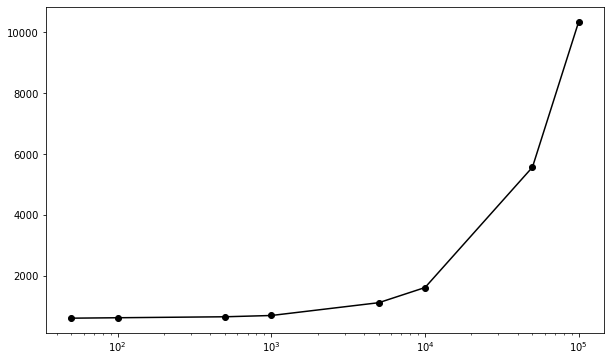

In [16]:
# for each time window count the number of coincidences and plot the number of coincidences as a function of the time window

coincidences = labra_coincidence.groupby("time_window").count()["board"]

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111)

ax.plot(coincidences.index, coincidences.values, marker="o", color="black")
ax.set_xscale("log")

plt.show()

In [20]:
# for each time window, count how many Gamma particles are found between two Neutron particles
counts = labra_coincidence.groupby(["time_window", "Particle"]).count()["board"]
counts


time_window  Particle
50.0         Gamma        309
             Neutron      309
100.0        Gamma        316
             Neutron      316
500.0        Gamma        332
             Neutron      332
1000.0       Gamma        353
             Neutron      353
5000.0       Gamma        563
             Neutron      563
10000.0      Gamma        812
             Neutron      812
50000.0      Gamma       2817
             Neutron     2756
100000.0     Gamma       5274
             Neutron     5075
Name: board, dtype: int64

In [22]:
def count_gamma_between_neutrons(df):
    # Find the indices of the Neutron particles
    neutron_indices = df[df["Particle"] == "Neutron"].index
    # Initialize an empty list to store the counts of Gamma particles
    gamma_counts = []
    # Iterate over the indices of the Neutron particles
    for i in range(len(neutron_indices) - 1):
        # Get the start and end indices for the current time window
        start_index = neutron_indices[i]
        end_index = neutron_indices[i+1]
        # Count the number of Gamma particles in the current time window
        gamma_count = df.loc[start_index:end_index, "Particle"].value_counts()["Gamma"]
        # Append the count to the list
        gamma_counts.append(gamma_count)
    # Return the list of counts
    return gamma_counts

# Group the dataframe by the "time_window" column
grouped_df = labra_coincidence.groupby("time_window")

# Apply the count_gamma_between_neutrons function to each group
gamma_counts_by_time_window = grouped_df.apply(count_gamma_between_neutrons)


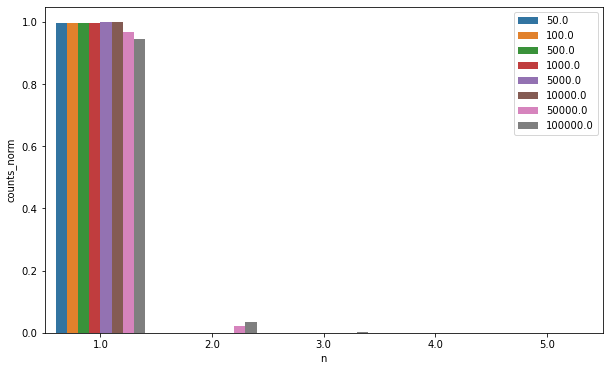

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

n_df = pd.DataFrame(columns=["time_window", "n", "counts"])

# Iterate over the time windows
for time_window, gamma_counts in gamma_counts_by_time_window.items():

    # compute how many ones there are in the gamma_counts list
    ones = gamma_counts.count(1)
    twos = gamma_counts.count(2)
    three = gamma_counts.count(3)
    four = gamma_counts.count(4)
    five = gamma_counts.count(5)
    
    n_df = n_df.append({"time_window": time_window, "n": 1, "counts": ones}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 2, "counts": twos}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 3, "counts": three}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 4, "counts": four}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 5, "counts": five}, ignore_index=True)
   
   
# normalize the counts to the total number of coincidences
for tw in time_windows:
    tot = labra_coincidence[labra_coincidence["time_window"] == tw].count()["board"]
    n_df.loc[n_df["time_window"] == tw, "counts_norm"] = n_df.loc[n_df["time_window"] == tw, "counts"] / tot * 2


ax = sns.barplot(x="n", y="counts_norm", hue="time_window", data=n_df, ax=ax) 
ax.legend()

plt.show()
    
    

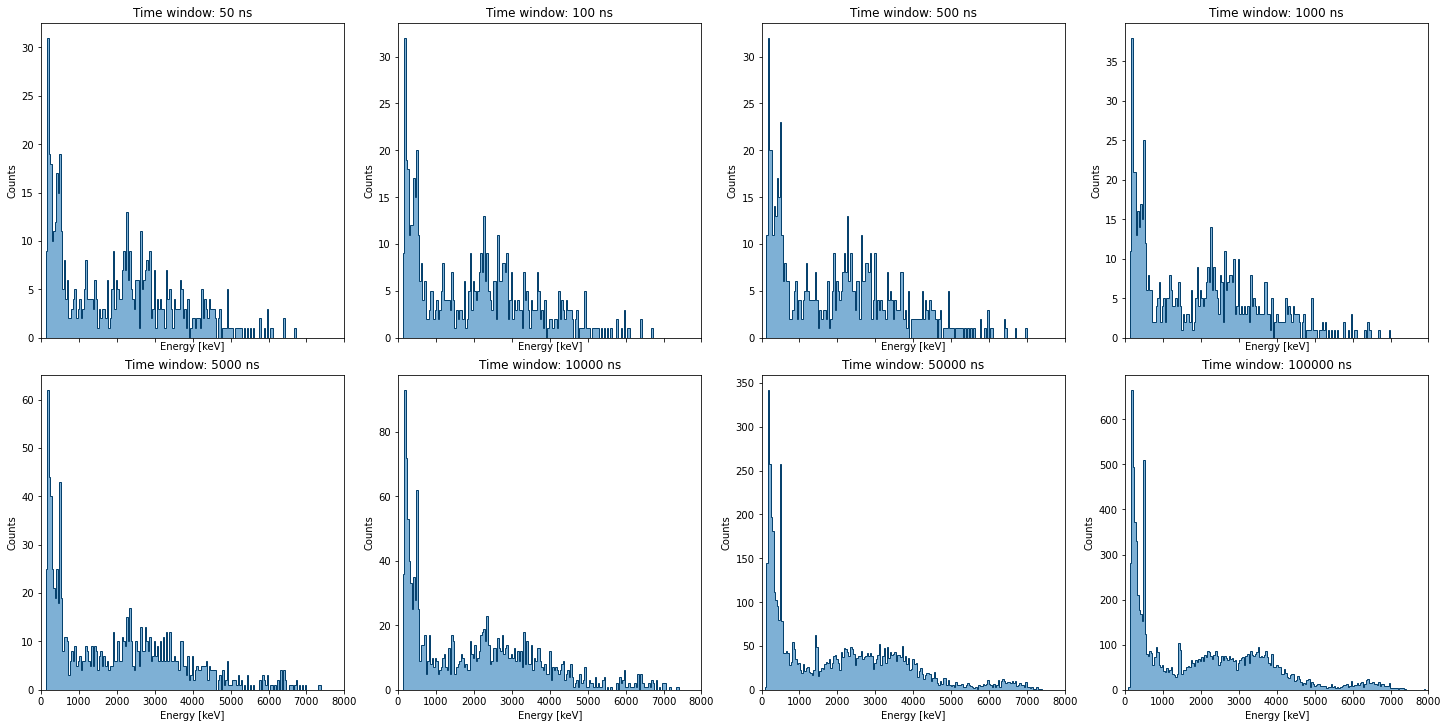

In [61]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True, sharex=True)

for i, tw in enumerate(time_windows):
    ax[i//4, i%4].hist(
        labra_coincidence[labra_coincidence["time_window"] == tw]["energy_calib"],
        bins      = np.linspace(0, 8000, 200), 
        histtype  = "stepfilled", 
        edgecolor = "#06416D", 
        facecolor = "#7eb0d5",
        label     = f"{tw} ns"
    )

    ax[i//4, i%4].set_xlim(0, 8000)
    ax[i//4, i%4].set_xlabel("Energy [keV]")
    ax[i//4, i%4].set_ylabel("Counts")

    ax[i//4, i%4].set_title(f"Time window: {int(tw)} ns")
    
    
fig.savefig("./plots/e_hist_coincidence_windows.png", dpi=300, facecolor="white")
plt.show()


### LaBr3 B

In [62]:
# read coincidence data
labrb_coincidence = pd.DataFrame(
    columns=['board', 'channel', 'flag', 'timestamp', 'energy', 'energy_short', 'energy_calib', 'energy_short_calib', 'psd', 'psd_calib', 'id', 'Particle', 'time_window']
)

for tw in time_windows:
    df = pd.read_csv(f"{DATA_PATH}/labrb-coincidence-{tw}ns.csv")
    df.loc[:, "time_window"] = tw
    labrb_coincidence = labrb_coincidence.append(df, ignore_index=True)

In [63]:
labrb_coincidence

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id,Particle,time_window
0,1,2,16384,1211581046218,604,185,3028.420253,906.901266,0.693709,0.700537,344,Neutron,50.0
1,1,0,16384,1211581045580,670,669,2372.076827,2368.554629,0.001493,0.001485,676,Gamma,50.0
2,1,2,16384,16627882362404,449,132,2243.610127,638.546835,0.706013,0.715393,4435,Neutron,50.0
3,1,0,16384,16627882362310,88,88,322.157425,322.157425,0.000000,0.000000,8775,Gamma,50.0
4,1,2,16384,230749976044811,357,102,1777.787342,486.648101,0.714286,0.726262,62052,Neutron,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14426,1,0,16384,7612223206485562,138,138,498.267339,498.267339,0.000000,0.000000,4202011,Gamma,100000.0
14427,1,2,16384,7612358253169061,286,83,1418.293671,390.445570,0.709790,0.724708,2162978,Neutron,100000.0
14428,1,0,16384,7612358245838725,303,303,1079.430056,1079.430056,0.000000,0.000000,4202090,Gamma,100000.0
14429,1,2,16384,7614357512066906,363,109,1808.167089,522.091139,0.699725,0.711259,2163540,Neutron,100000.0


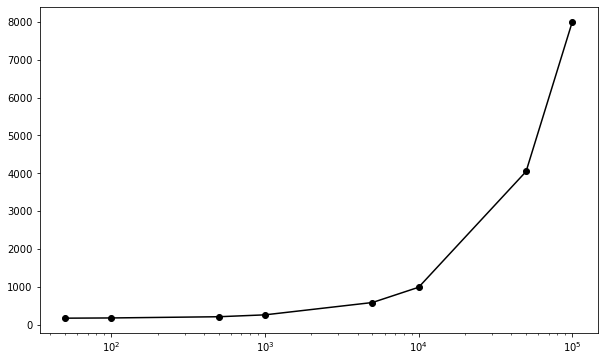

In [64]:
# for each time window count the number of coincidences and plot the number of coincidences as a function of the time window

coincidences = labrb_coincidence.groupby("time_window").count()["board"]

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111)

ax.plot(coincidences.index, coincidences.values, marker="o", color="black")
ax.set_xscale("log")

plt.show()

In [65]:
# for each time window, count how many Gamma particles are found between two Neutron particles
counts = labrb_coincidence.groupby(["time_window", "Particle"]).count()["board"]
counts


time_window  Particle
50.0         Gamma         84
             Neutron       84
100.0        Gamma         87
             Neutron       87
500.0        Gamma        103
             Neutron      103
1000.0       Gamma        128
             Neutron      128
5000.0       Gamma        291
             Neutron      291
10000.0      Gamma        494
             Neutron      492
50000.0      Gamma       2042
             Neutron     2006
100000.0     Gamma       4066
             Neutron     3945
Name: board, dtype: int64

In [66]:
def count_gamma_between_neutrons(df):
    # Find the indices of the Neutron particles
    neutron_indices = df[df["Particle"] == "Neutron"].index
    # Initialize an empty list to store the counts of Gamma particles
    gamma_counts = []
    # Iterate over the indices of the Neutron particles
    for i in range(len(neutron_indices) - 1):
        # Get the start and end indices for the current time window
        start_index = neutron_indices[i]
        end_index = neutron_indices[i+1]
        # Count the number of Gamma particles in the current time window
        gamma_count = df.loc[start_index:end_index, "Particle"].value_counts()["Gamma"]
        # Append the count to the list
        gamma_counts.append(gamma_count)
    # Return the list of counts
    return gamma_counts

# Group the dataframe by the "time_window" column
grouped_df = labrb_coincidence.groupby("time_window")

# Apply the count_gamma_between_neutrons function to each group
gamma_counts_by_time_window = grouped_df.apply(count_gamma_between_neutrons)


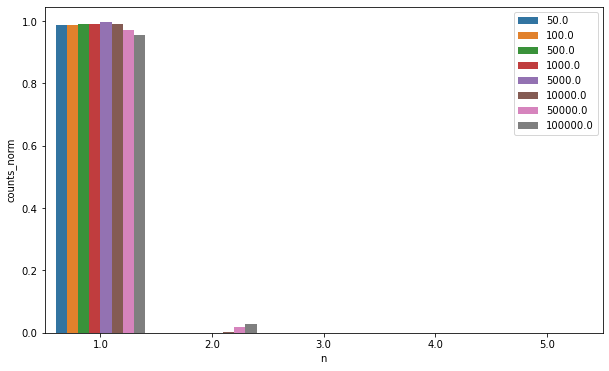

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

n_df = pd.DataFrame(columns=["time_window", "n", "counts"])

# Iterate over the time windows
for time_window, gamma_counts in gamma_counts_by_time_window.items():

    # compute how many ones there are in the gamma_counts list
    ones = gamma_counts.count(1)
    twos = gamma_counts.count(2)
    three = gamma_counts.count(3)
    four = gamma_counts.count(4)
    five = gamma_counts.count(5)
    
    n_df = n_df.append({"time_window": time_window, "n": 1, "counts": ones}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 2, "counts": twos}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 3, "counts": three}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 4, "counts": four}, ignore_index=True)
    n_df = n_df.append({"time_window": time_window, "n": 5, "counts": five}, ignore_index=True)
   
   
# normalize the counts to the total number of coincidences
for tw in time_windows:
    tot = labrb_coincidence[labrb_coincidence["time_window"] == tw].count()["board"]
    n_df.loc[n_df["time_window"] == tw, "counts_norm"] = n_df.loc[n_df["time_window"] == tw, "counts"] / tot * 2


ax = sns.barplot(x="n", y="counts_norm", hue="time_window", data=n_df, ax=ax) 
ax.legend()

plt.show()
    
    

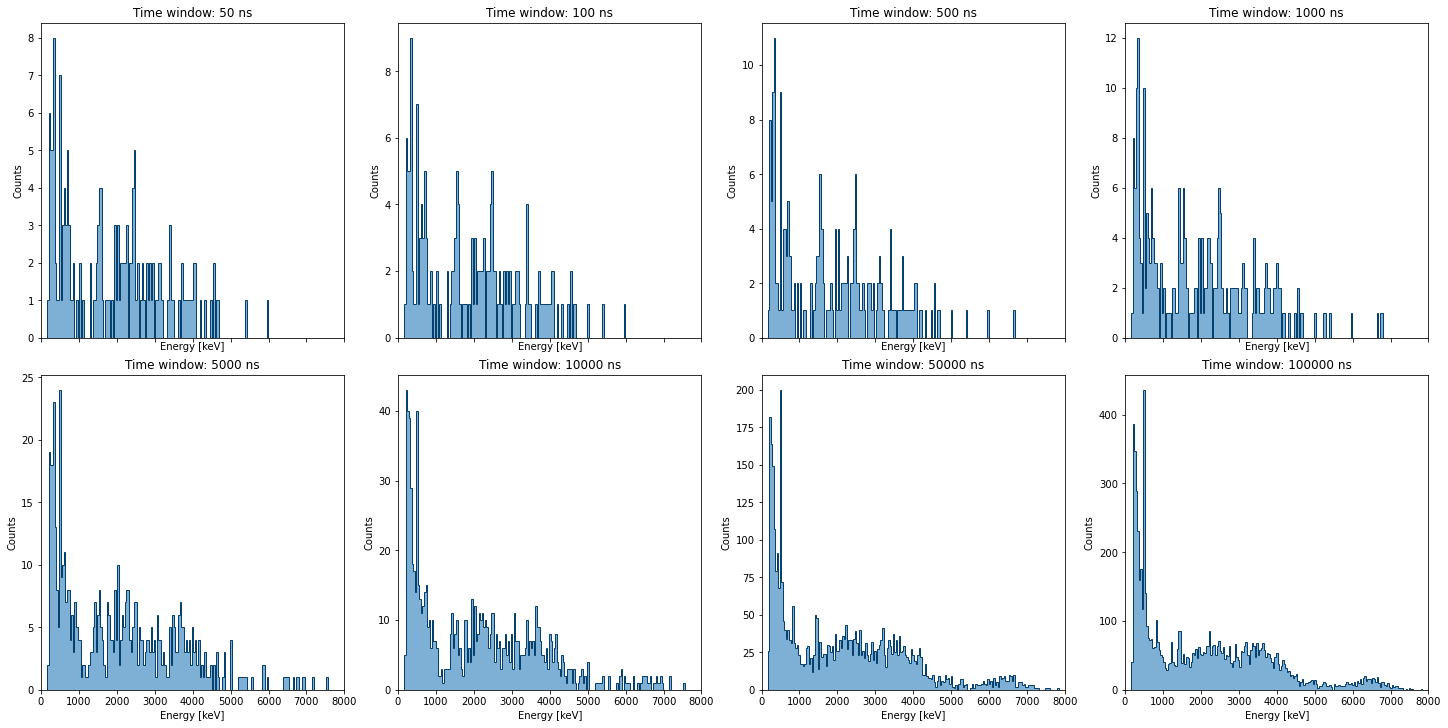

In [69]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True, sharex=True)

for i, tw in enumerate(time_windows):
    ax[i//4, i%4].hist(
        labrb_coincidence[labrb_coincidence["time_window"] == tw]["energy_calib"],
        bins      = np.linspace(0, 8000, 200), 
        histtype  = "stepfilled", 
        edgecolor = "#06416D", 
        facecolor = "#7eb0d5",
        label     = f"{tw} ns"
    )

    ax[i//4, i%4].set_xlim(0, 8000)
    ax[i//4, i%4].set_xlabel("Energy [keV]")
    ax[i//4, i%4].set_ylabel("Counts")

    ax[i//4, i%4].set_title(f"Time window: {int(tw)} ns")
    
    
fig.savefig("./plots/labrb_e_hist_coincidence_windows.png", dpi=300, facecolor="white")
plt.show()
